In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.datasets

In [2]:
# generate an artificial classification problem

N = 50

# Observations from class A and B come from two normal
# distributions with different mean, but same covariance
mean_classA = np.array([-1 , -1])
mean_classB = np.array([1 , 1])
cov = 1*np.identity(n=2)

X_classA = np.random.multivariate_normal(mean_classA, cov, N//2)
X_classB = np.random.multivariate_normal(mean_classB, cov, N//2)
X = np.concatenate((X_classA, X_classB))

y_classA = np.full((N//2, ), 1, dtype=np.bool_)
y_classB = np.full((N//2, ), 0, dtype=np.bool_)
y = np.concatenate((y_classA, y_classB))

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X.shape, y.shape

(torch.Size([50, 2]), torch.Size([50]))

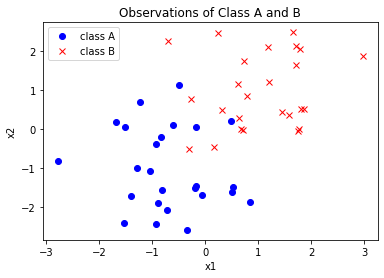

In [3]:
plt.plot(X_classA[:, 0], X_classA[:, 1], "bo", label="class A")
plt.plot(X_classB[:, 0], X_classB[:, 1], "rx", label="class B")
plt.title("Observations of Class A and B")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

## Simple Neural Network using Pytorch

The neural network will be equivalent to a logistic regression.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 1, bias=True) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

**Visualization of the Network**

<img src="https://i.imgur.com/mXJD4Pf.png" alt="Drawing" style="width: 500px;"/>

The network has 3 learnable weights, thereof

* 2 weights $w_1, w_2$ associated with the single hidden unit $a_1$
* 1 weight $b$ for the bias of the hidden layer

Final Accuracy: 92.0%


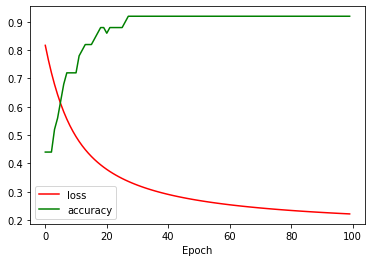

In [5]:
# training loop 
net = Net()
criterion = nn.BCELoss()
optim = torch.optim.SGD(net.parameters(), lr=0.1)

EPOCHS = 100
losses = []
accuracies = []
for i in range(EPOCHS):
    net.zero_grad()
    out = net(X)
    out = out.reshape((-1, )) # from (N, 1) to (N, )
    
    loss = criterion(out, y)
    losses.append(loss)
    
    preds = out > 0.5
    accuracy = np.sum(preds.detach().numpy() == y.numpy()) / X.shape[0]
    accuracies.append(accuracy)
    
    loss.backward()
    optim.step()


print(f"Final Accuracy: {accuracy*100}%")

plt.plot(losses, "r-", label="loss")
plt.plot(accuracies, "g-", label="accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [6]:
# print learnable parameters
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.data)

weights = [param.data for name, param in net.named_parameters() if "weight" in name][0].reshape(-1,)
bias = [param.data for name, param in net.named_parameters() if "bias" in name][0]

fc1.weight tensor([[-1.1699, -1.2947]])
fc1.bias tensor([0.1453])


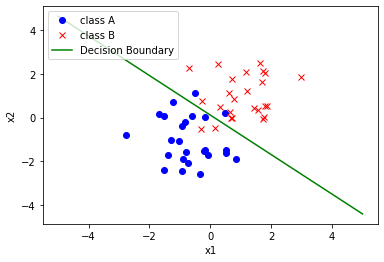

In [7]:
# plot the learned decision boundary

# **Derivation**
#      0 = b + w0*x1 + w1*x2
# <=> x2 = -b/w1 -(wo/w1)*x1

def decision_boundary(x1, bias, weights):
    intercept = -bias/weights[1]
    slope = -weights[0]/weights[1]
    return intercept + slope*x1

xx = np.linspace(-5, 5, 50)
yy = decision_boundary(xx, bias, weights)

plt.plot(X_classA[:, 0], X_classA[:, 1], "bo", label="class A")
plt.plot(X_classB[:, 0], X_classB[:, 1], "rx", label="class B")
plt.plot(xx, yy, "g-", label="Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(loc="upper left")
plt.show()

## The same neural network, but *from scratch* (with the help of Autograd)

In [8]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def cross_entropy_loss(preds, targets):
    losses = -(targets*torch.log(preds) + (1-targets)*torch.log(1-preds))
    loss = losses.mean()
    return loss

In [9]:
# init learnable weights of the network
W = torch.rand((2, 1), requires_grad=True)
b = torch.rand((1, ), requires_grad=True)

print(W)
print(b)

tensor([[0.5020],
        [0.5932]], requires_grad=True)
tensor([0.0179], requires_grad=True)


In [10]:
# forward path
print((X.shape, W.shape, b.shape))

out = X@W + b 
print(out.shape)

out = torch.reshape(out, (out.shape[0], ))
print(out.shape)

preds = sigmoid(out)
print(preds.shape)

preds

(torch.Size([50, 2]), torch.Size([2, 1]), torch.Size([1]))
torch.Size([50, 1])
torch.Size([50])
torch.Size([50])


tensor([0.2279, 0.3265, 0.1302, 0.3514, 0.3282, 0.3362, 0.1348, 0.1533, 0.4883,
        0.1016, 0.2720, 0.6075, 0.2120, 0.5929, 0.2403, 0.3367, 0.2804, 0.1748,
        0.3346, 0.2651, 0.3711, 0.4421, 0.4521, 0.1558, 0.1701, 0.5871, 0.4555,
        0.7307, 0.3917, 0.8319, 0.7118, 0.7029, 0.7353, 0.9315, 0.7306, 0.6219,
        0.6153, 0.8949, 0.7303, 0.7735, 0.8044, 0.7131, 0.8649, 0.5866, 0.8941,
        0.7790, 0.9099, 0.7897, 0.5838, 0.8640], grad_fn=<MulBackward0>)

In [11]:
# autograd & weight update
loss = cross_entropy_loss(preds=preds, targets=y)
loss.backward()

print(W.grad)
print(b.grad)

LEARN_RATE = 0.01
W = W - LEARN_RATE * W.grad
b = b - LEARN_RATE * b.grad

tensor([[0.6828],
        [0.8199]])
tensor([0.0144])


Putting it all together

In [12]:
X.shape, y.shape

(torch.Size([50, 2]), torch.Size([50]))

tensor([[-1.1993],
        [-1.2052]], requires_grad=True)
tensor([0.2474], requires_grad=True)
final accuracy:92.0%


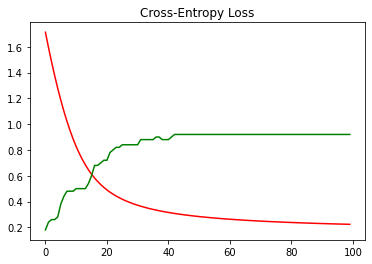

In [13]:
W = torch.rand((2, 1), requires_grad=True)
b = torch.rand((1, ), requires_grad=True)

EPOCHS = 100
LEARN_RATE = 0.1
losses = []
accuracies = []
for i in range(EPOCHS):
    out = X@W + b
    out = out.reshape((X.shape[0], ))
    preds = sigmoid(out)
    loss = cross_entropy_loss(preds=preds, targets=y)
    losses.append(loss)
    
    # accuracy
    pred_classes = preds > 0.5
    accuracy = np.sum(pred_classes.detach().numpy() == y.numpy()) / X.shape[0]
    accuracies.append(accuracy)
    
    # backward path
    loss.backward()
    
    # weight update
    W = W - LEARN_RATE * W.grad
    b = b - LEARN_RATE * b.grad
    
    # Reset the gradient for the next batch
    W = W.detach()
    b = b.detach()
    W.requires_grad = True
    b.requires_grad = True

# Plot the results
print(W)
print(b)
print(f"final accuracy:{accuracy*100}%")
plt.plot(losses, "r-")
plt.plot(accuracies, "g-")
plt.title("Cross-Entropy Loss")
plt.show()

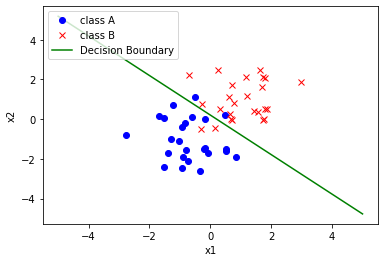

In [15]:
# plot the learned decision boundary
W = W.detach().numpy()
b = b.detach().numpy()

xx = np.linspace(-5, 5, 50)
yy = decision_boundary(xx, bias=b, weights=W)

plt.plot(X_classA[:, 0], X_classA[:, 1], "bo", label="class A")
plt.plot(X_classB[:, 0], X_classB[:, 1], "rx", label="class B")
plt.plot(xx, yy, "g-", label="Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(loc="upper left")
plt.show()